# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [1]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

In [7]:
class GradientBoosting(BaseEstimator):
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1, opt_gamma=True):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gammas = [1] * n_estimators
        self.trees = []
        self.opt_gamma = opt_gamma
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        a = 0
        
        for i in range(self.n_estimators):
            y_new = y - a
            pred = self._fit_predict_tree(x, y_new)
            a += pred

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth).fit(x, y)
        tree_pred = tree.predict(x)
        if self.opt_gamma:   # ищем оптимальную гамму
            cur_y_pred = self.predict(x)
            optimal_gamma = minimize(fun=lambda w: np.mean(np.square(cur_y_pred + w * tree_pred - y)),
                                     x0=np.array([1])).x[0]
            self.gammas.append(optimal_gamma)
        self.trees.append(tree)
        return self.gammas[-1] * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.ones([x.shape[0]]) 
        for i in range(len(self.trees)):
            y_pred += self.gammas[i] * self.learning_rate * self.trees[i].predict(x).reshape([x.shape[0]])
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

# Без оптимальной gamma:

In [8]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=50, max_depth=3, opt_gamma=False)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

13.724325317252044

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
np.random.seed(19052019)
params = {
    'n_estimators': [30, 50, 100, 150, 200, 450],
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [1e-3, 1e-2, 0.1, 0.2, 0.3]
}

gb = GradientBoosting(opt_gamma=False)
gsearch = GridSearchCV(estimator=gb,
                       param_grid=params,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       verbose=3)
gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 1/5] END learning_rate=0.001, max_depth=1, n_estimators=30;, score=-473.141 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=30;, score=-464.014 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=30;, score=-567.215 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=30;, score=-569.359 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=1, n_estimators=30;, score=-549.124 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-454.395 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-446.401 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-546.692 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-548.723 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=1,

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=1, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=1, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=200;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=1, n_estimators=450;, score=nan total time=   0.2s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=30;, score=-472.753 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=30;, score=-462.404 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=30;, score=-565.992 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=30;, score=-567.224 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=30;, score=-548.113 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-453.307 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-444.550 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-544.582 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-545.160 total time=   0.0s
[CV 5/5] END l

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=450;, score=nan total time=   0.3s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=30;, score=-473.079 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=30;, score=-461.959 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=30;, score=-566.360 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=30;, score=-566.666 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=30;, score=-547.399 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=50;, score=-453.864 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=50;, score=-443.747 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=50;, score=-545.168 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=50;, score=-544.297 total time=   0.0s
[CV 5/5] END l

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=150;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=150;, score=nan total time=   0.1s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=nan total time=   0.1s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=nan total time=   0.1s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=450;, score=nan total time=   0.3s
[CV 1/5] END learning_rate=0.001, max_depth=4, n_estimators=30;, score=-472.684 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=4, n_estimators=30;, score=-461.392 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=4, n_estimators=30;, score=-566.360 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=4, n_estimators=30;, score=-565.997 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=4, n_estimators=30;, score=-547.037 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=4, n_estimators=50;, score=-453.255 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=4, n_estimators=50;, score=-442.989 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=4, n_estimators=50;, score=-545.122 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=4, n_estimators=50;, score=-543.295 total time=   0.0s
[CV 5/5] END l

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=4, n_estimators=150;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.001, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=4, n_estimators=150;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=4, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.001, max_depth=4, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=4, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=4, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.001, max_depth=4, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=4, n_estimators=450;, score=nan total time=   0.5s
[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=30;, score=-472.618 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=30;, score=-461.065 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=30;, score=-566.666 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=30;, score=-566.367 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=5, n_estimators=30;, score=-547.099 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=-453.137 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=-442.444 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=-545.327 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=-543.938 total time=   0.0s
[CV 5/5] END l

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.001, max_depth=5, n_estimators=450;, score=nan total time=   0.5s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-275.001 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-273.900 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-349.049 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-344.621 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=30;, score=-335.202 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=50;, score=-185.435 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=50;, score=-188.175 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=50;, score=-248.091 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=50;, score=-240.753 total time=   0.0s
[CV 5/5] END learning_r

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=450;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=450;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=450;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=450;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=450;, score=nan total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=30;, score=-269.050 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=30;, score=-269.225 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=30;, score=-338.935 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=30;, score=-330.953 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=30;, score=-328.319 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=50;, score=-177.657 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=50;, score=-181.776 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=50;, score=-235.358 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=50;, score=-223.922 total time=   0.0s
[CV 5/5] END learning_ra

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=450;, score=nan total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=30;, score=-269.290 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=30;, score=-266.302 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=30;, score=-338.025 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=30;, score=-323.874 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=30;, score=-323.725 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=-176.614 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=-177.907 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=-231.371 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=-212.450 total time=   0.0s
[CV 5/5] END learning_ra

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=150;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=150;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=nan total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=nan total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=450;, score=nan total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=30;, score=-267.633 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=30;, score=-264.615 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=30;, score=-338.475 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=30;, score=-322.015 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=30;, score=-319.742 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=50;, score=-175.451 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=50;, score=-174.705 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=50;, score=-232.069 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=50;, score=-211.594 total time=   0.0s
[CV 5/5] END learning_ra

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=150;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=150;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=450;, score=nan total time=   0.4s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=30;, score=-266.467 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=30;, score=-263.592 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=30;, score=-339.331 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=30;, score=-325.133 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=30;, score=-316.693 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=50;, score=-174.388 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=50;, score=-173.948 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=50;, score=-234.597 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=50;, score=-215.275 total time=   0.0s
[CV 5/5] END learning_ra

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=150;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=150;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=450;, score=nan total time=   0.5s
[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=30;, score=-18.038 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=30;, score=-24.349 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=30;, score=-27.762 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=30;, score=-22.561 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=30;, score=-25.679 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=50;, score=-17.904 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=50;, score=-21.455 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=50;, score=-19.118 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=50;, score=-19.027 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=200;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=450;, score=nan total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=30;, score=-12.502 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=30;, score=-14.989 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=30;, score=-16.652 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=30;, score=-12.774 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=30;, score=-18.876 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=50;, score=-14.492 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=50;, score=-13.858 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=50;, score=-11.950 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=50;, score=-12.617 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=2

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=200;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=200;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=450;, score=nan total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=30;, score=-10.840 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=30;, score=-10.028 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=30;, score=-13.330 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=30;, score=-9.671 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=30;, score=-11.642 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=-10.510 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=-10.305 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=-10.915 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=-9.427 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, 

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=150;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=150;, score=nan total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=nan total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=nan total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=450;, score=nan total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=30;, score=-10.614 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=30;, score=-7.346 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=30;, score=-14.574 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=30;, score=-9.053 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=30;, score=-9.719 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=50;, score=-12.418 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=50;, score=-7.693 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=50;, score=-12.065 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=50;, score=-8.829 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_e

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=150;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=150;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=450;, score=nan total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=30;, score=-9.637 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=30;, score=-7.449 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=30;, score=-15.381 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=30;, score=-9.895 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=30;, score=-9.781 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=50;, score=-12.313 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=50;, score=-8.136 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=50;, score=-14.346 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=50;, score=-9.818 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_es

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=450;, score=nan total time=   0.5s
[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=30;, score=-18.964 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=30;, score=-20.247 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=30;, score=-16.468 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=30;, score=-17.688 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=30;, score=-24.587 total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=50;, score=-18.931 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=50;, score=-17.628 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=50;, score=-12.845 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=50;, score=-17.228 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=1

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=200;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=450;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=450;, score=nan total time=   0.2s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=30;, score=-12.338 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=30;, score=-14.258 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=30;, score=-11.533 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=30;, score=-12.945 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=30;, score=-14.528 total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=50;, score=-12.400 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=50;, score=-12.507 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=50;, score=-10.150 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=50;, score=-12.305 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=2

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=450;, score=nan total time=   0.3s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=30;, score=-13.993 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=30;, score=-9.891 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=30;, score=-11.251 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=30;, score=-9.761 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=30;, score=-9.565 total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=50;, score=-13.361 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=50;, score=-9.483 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=50;, score=-10.773 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=50;, score=-9.493 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_e

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=150;, score=nan total time=   0.1s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=nan total time=   0.1s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=450;, score=nan total time=   0.3s
[CV 1/5] END learning_rate=0.2, max_depth=4, n_estimators=30;, score=-12.693 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=4, n_estimators=30;, score=-8.949 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=4, n_estimators=30;, score=-11.577 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=30;, score=-8.814 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=4, n_estimators=30;, score=-7.702 total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=4, n_estimators=50;, score=-12.481 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=4, n_estimators=50;, score=-9.042 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=4, n_estimators=50;, score=-10.654 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=50;, score=-8.525 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=4, n_e

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=4, n_estimators=150;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.2, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=4, n_estimators=150;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.2, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=4, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=4, n_estimators=450;, score=nan total time=   0.6s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=4, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.2, max_depth=4, n_estimators=450;, score=nan total time=   0.4s
[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=30;, score=-12.418 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=30;, score=-8.417 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=30;, score=-14.542 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=30;, score=-9.804 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=30;, score=-8.583 total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=50;, score=-12.183 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=50;, score=-8.991 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=50;, score=-13.617 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=50;, score=-9.807 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=5, n_e

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=150;, score=nan total time=   0.1s
[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=450;, score=nan total time=   0.6s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=450;, score=nan total time=   0.6s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=450;, score=nan total time=   0.6s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=450;, score=nan total time=   0.6s
[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=30;, score=-18.436 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=30;, score=-18.227 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=1, n_estimators=30;, score=-13.413 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=1, n_estimators=30;, score=-17.857 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=1, n_estimators=30;, score=-23.436 total time=   0.0s
[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=50;, score=-18.108 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=50;, score=-15.474 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=1, n_estimators=50;, score=-11.430 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=1, n_estimators=50;, score=-16.430 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=1

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=1, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.3, max_depth=1, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=1, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=1, n_estimators=200;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=1, n_estimators=200;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=1, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.3, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.3, max_depth=1, n_estimators=450;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=1, n_estimators=450;, score=nan total time=   0.2s
[CV 1/5] END learning_rate=0.3, max_depth=2, n_estimators=30;, score=-14.400 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=30;, score=-15.901 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=30;, score=-9.867 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=2, n_estimators=30;, score=-14.096 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=2, n_estimators=30;, score=-15.863 total time=   0.0s
[CV 1/5] END learning_rate=0.3, max_depth=2, n_estimators=50;, score=-14.107 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=50;, score=-14.984 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=50;, score=-8.858 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=2, n_estimators=50;, score=-14.461 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=2, 

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.3, max_depth=2, n_estimators=150;, score=nan total time=   0.1s
[CV 5/5] END learning_rate=0.3, max_depth=2, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=2, n_estimators=200;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=200;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.3, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=2, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=2, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.3, max_depth=2, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=2, n_estimators=450;, score=nan total time=   0.3s
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=-11.525 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=-8.967 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=-9.054 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=-9.045 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=-9.864 total time=   0.0s
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=50;, score=-12.838 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=50;, score=-8.713 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=50;, score=-8.899 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=50;, score=-8.980 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=3, n_est

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=150;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=150;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=150;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=3, n_estimators=150;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=nan total time=   0.1s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=450;, score=nan total time=   0.3s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=3, n_estimators=450;, score=nan total time=   0.3s
[CV 1/5] END learning_rate=0.3, max_depth=4, n_estimators=30;, score=-14.919 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=4, n_estimators=30;, score=-9.304 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=4, n_estimators=30;, score=-12.579 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=4, n_estimators=30;, score=-10.285 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=4, n_estimators=30;, score=-7.382 total time=   0.0s
[CV 1/5] END learning_rate=0.3, max_depth=4, n_estimators=50;, score=-15.317 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=4, n_estimators=50;, score=-9.153 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=4, n_estimators=50;, score=-10.989 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=4, n_estimators=50;, score=-10.592 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=4, n

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=4, n_estimators=150;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.3, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.3, max_depth=4, n_estimators=150;, score=nan total time=   0.2s
[CV 5/5] END learning_rate=0.3, max_depth=4, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=4, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.3, max_depth=4, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=4, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.3, max_depth=4, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=4, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=4, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.3, max_depth=4, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=4, n_estimators=450;, score=nan total time=   0.4s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.3, max_depth=4, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=4, n_estimators=450;, score=nan total time=   0.4s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=30;, score=-14.248 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=30;, score=-8.785 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=30;, score=-13.759 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=30;, score=-10.065 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=30;, score=-7.760 total time=   0.0s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=50;, score=-12.667 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=50;, score=-8.829 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=50;, score=-12.878 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=50;, score=-10.127 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=5, n

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=150;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=150;, score=nan total time=   0.1s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=150;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=nan total time=   0.2s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=nan total time=   0.2s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=450;, score=nan total time=   0.6s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=450;, score=nan total time=   0.6s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=450;, score=nan total time=   0.5s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=450;, score=nan total time=   0.5s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

GridSearchCV(cv=5, estimator=GradientBoosting(opt_gamma=False),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [30, 50, 100, 150, 200, 450]},
             scoring='neg_mean_squared_error', verbose=3)

In [14]:
gsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [18]:
np.random.seed(19052019)
params = {
    'n_estimators': np.arange(90, 120, 5),
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.15]
}

gb = GradientBoosting(opt_gamma=False)
gsearch = GridSearchCV(estimator=gb,
                       param_grid=params,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       verbose=3)
gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END learning_rate=0.05, max_depth=2, n_estimators=90;, score=-12.315 total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=90;, score=-14.217 total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=90;, score=-12.608 total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=90;, score=-12.803 total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=90;, score=-17.269 total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=2, n_estimators=95;, score=-12.658 total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=95;, score=-14.061 total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=95;, score=-12.266 total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=95;, score=-12.846 total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=95;, s

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=105;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=105;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.05, max_depth=2, n_estimators=110;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=110;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=110;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=110;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=2, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=90;, score=-10.889 total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=90;, score=-10.009 total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=90;, score=-11.241 total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=90;, score=-9.451 total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=90;, score=-10.345 total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=95;, score=-11.124 total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=95;, score=-9.994 total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=95;, score=-11.126 total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=95;, score=-9.524 total time=   0.0s
[CV 5/5] END learning_rate=0.05, max

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=105;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=105;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=110;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=110;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=110;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.05, max_depth=3, n_estimators=115;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.05, max_depth=3, n_estimators=115;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=3, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.05, max_depth=4, n_estimators=90;, score=-11.780 total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=4, n_estimators=90;, score=-7.736 total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=4, n_estimators=90;, score=-12.187 total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=4, n_estimators=90;, score=-8.363 total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=4, n_estimators=90;, score=-8.215 total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=4, n_estimators=95;, score=-12.508 total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=4, n_estimators=95;, score=-7.828 total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=4, n_estimators=95;, score=-11.946 total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=4, n_estimators=95;, score=-8.199 total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=4, n_estimators=95;, score=-8.049 total time=   0.0s
[CV 1/5] END learning_rate=0.05, max

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.05, max_depth=4, n_estimators=105;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=4, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.05, max_depth=4, n_estimators=105;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=4, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.05, max_depth=4, n_estimators=105;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=4, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.05, max_depth=4, n_estimators=110;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=4, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.05, max_depth=4, n_estimators=110;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=4, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.05, max_depth=4, n_estimators=115;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=4, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.05, max_depth=4, n_estimators=115;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=4, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.05, max_depth=4, n_estimators=115;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=90;, score=-14.502 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=90;, score=-12.119 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=90;, score=-9.985 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=90;, score=-12.278 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=90;, score=-15.930 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=95;, score=-14.624 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=95;, score=-12.096 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=95;, score=-9.900 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=95;, score=-12.330 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=2,

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=105;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=105;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=105;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=105;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=110;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=110;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=110;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=90;, score=-10.992 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=90;, score=-9.855 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=90;, score=-9.614 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=90;, score=-9.061 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=90;, score=-8.257 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=95;, score=-10.434 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=95;, score=-9.732 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimat

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=105;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=105;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=110;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=110;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=110;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=115;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=115;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=90;, score=-13.237 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=90;, score=-8.015 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=90;, score=-11.286 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=90;, score=-8.977 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=90;, score=-7.305 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=95;, score=-14.246 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=95;, score=-7.846 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=95;, score=-11.855 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=95;, score=-8.946 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=95;, score=-7.289 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=4, n

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=105;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=105;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=110;, score=nan total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=110;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=110;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=115;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=115;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=115;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.15, max_depth=2, n_estimators=90;, score=-12.419 total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.15, max_depth=2, n_estimators=90;, score=-11.880 total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=2, n_estimators=90;, score=-9.497 total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_depth=2, n_estimators=90;, score=-11.896 total time=   0.0s
[CV 5/5] END learning_rate=0.15, max_depth=2, n_estimators=90;, score=-14.874 total time=   0.0s
[CV 1/5] END learning_rate=0.15, max_depth=2, n_estimators=95;, score=-12.368 total time=   0.0s
[CV 2/5] END learning_rate=0.15, max_depth=2, n_estimators=95;, score=-11.779 total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=2, n_estimators=95;, score=-9.264 total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_depth=2, n_estimators=95;, score=-11.715 total time=   0.0s
[CV 5/5] END learning_rate=0.15, max_depth=2, n_estimators=95;, score=-14.791 total time=   0.0s
[CV 1/5] END learning_rate=0.15, max_depth=2, n_estimators=100;, score=-12.406 total time=   0.0s
[CV 2/5] END learning_rate=0.15

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.15, max_depth=2, n_estimators=105;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=2, n_estimators=105;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_depth=2, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.15, max_depth=2, n_estimators=105;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.15, max_depth=2, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.15, max_depth=2, n_estimators=110;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=2, n_estimators=110;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_depth=2, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.15, max_depth=2, n_estimators=110;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.15, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.15, max_depth=2, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.15, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.15, max_depth=2, n_estimators=115;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.15, max_depth=3, n_estimators=90;, score=-10.249 total time=   0.0s
[CV 2/5] END learning_rate=0.15, max_depth=3, n_estimators=90;, score=-9.473 total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=3, n_estimators=90;, score=-10.117 total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_depth=3, n_estimators=90;, score=-9.520 total time=   0.0s
[CV 5/5] END learning_rate=0.15, max_depth=3, n_estimators=90;, score=-8.530 total time=   0.0s
[CV 1/5] END learning_rate=0.15, max_depth=3, n_estimators=95;, score=-10.252 total time=   0.0s
[CV 2/5] END learning_rate=0.15, max_depth=3, n_estimators=95;, score=-9.517 total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.15, max_depth=3, n_estimators=105;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.15, max_depth=3, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.15, max_depth=3, n_estimators=105;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_depth=3, n_estimators=105;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.15, max_depth=3, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.15, max_depth=3, n_estimators=110;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.15, max_depth=3, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.15, max_depth=3, n_estimators=110;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_depth=3, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.15, max_depth=3, n_estimators=110;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.15, max_depth=3, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.15, max_depth=3, n_estimators=115;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=3, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.15, max_depth=3, n_estimators=115;, score=nan total time=   0.1s
[CV 5/5] END learning_rate=0.15, max_depth=3, n_estimators=115;, score=nan total time=   0.1s
[CV 1/5] END learning_rate=0.15, max_depth=4, n_estimators=90;, score=-12.175 total time=   0.0s
[CV 2/5] END learning_rate=0.15, max_depth=4, n_estimators=90;, score=-8.967 total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=4, n_estimators=90;, score=-11.602 total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_depth=4, n_estimators=90;, score=-9.251 total time=   0.0s
[CV 5/5] END learning_rate=0.15, max_depth=4, n_estimators=90;, score=-7.375 total time=   0.0s
[CV 1/5] END learning_rate=0.15, max_depth=4, n_estimators=95;, score=-12.041 total time=   0.0s
[CV 2/5] END learning_rate=0.15, max_depth=4, n_estimators=95;, score=-9.353 total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=4, n_estimators=95;, score=-11.064 total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_dep

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.15, max_depth=4, n_estimators=105;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=4, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.15, max_depth=4, n_estimators=105;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.15, max_depth=4, n_estimators=105;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 1/5] END learning_rate=0.15, max_depth=4, n_estimators=110;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=0.15, max_depth=4, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 3/5] END learning_rate=0.15, max_depth=4, n_estimators=110;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=0.15, max_depth=4, n_estimators=110;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 5/5] END learning_rate=0.15, max_depth=4, n_estimators=110;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=0.15, max_depth=4, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 2/5] END learning_rate=0.15, max_depth=4, n_estimators=115;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=0.15, max_depth=4, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

[CV 4/5] END learning_rate=0.15, max_depth=4, n_estimators=115;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=0.15, max_depth=4, n_estimators=115;, score=nan total time=   0.0s


c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(est

GridSearchCV(cv=5, estimator=GradientBoosting(opt_gamma=False),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4],
                         'n_estimators': array([ 90,  95, 100, 105, 110, 115])},
             scoring='neg_mean_squared_error', verbose=3)

In [19]:
gsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 95}

In [20]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=95, max_depth=3, learning_rate=0.1, opt_gamma=False)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

13.91346864219919

# C оптимальной gamma

In [21]:
np.random.seed(19052019)
params = {
    'n_estimators': [30, 50, 100, 150, 200, 450],
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [1e-3, 1e-2, 0.1, 0.2, 0.3]
}

gb = GradientBoosting()
gsearch = GridSearchCV(estimator=gb,
                       param_grid=params,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       verbose=3)
gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 1/5] END learning_rate=0.001, max_depth=1, n_estimators=30;, score=-473.072 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=30;, score=-463.995 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=30;, score=-567.191 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=30;, score=-569.335 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=1, n_estimators=30;, score=-549.101 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-454.284 total time=   0.1s
[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-446.448 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-546.567 total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-548.649 total time=   0.1s
[CV 5/5] END learning_rate=0.001, max_depth=1,

[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=-415.628 total time=   2.9s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=-406.585 total time=   2.8s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=-397.783 total time=   3.4s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=450;, score=-228.502 total time=  11.8s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=450;, score=-226.950 total time=  12.4s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=450;, score=-291.520 total time=  13.2s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=450;, score=-275.163 total time=  10.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=450;, score=-278.227 total time=   9.7s
[CV 1/5] END learning_rate=0.001, max_depth=4, n_estimators=30;, score=-472.677 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=4, n_estimators=30;, score=-461.372 total time=   0.0s
[C

[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=-32.985 total time=   1.0s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=-35.779 total time=   1.0s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=-42.442 total time=   1.0s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=-37.988 total time=   1.0s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=-37.972 total time=   1.0s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=-38.509 total time=   2.4s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=-40.328 total time=   2.0s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=-43.405 total time=   2.0s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=-39.059 total time=   1.7s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=-39.198 total time=   2.0s
[CV 1/5] END learnin

[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=50;, score=-203.682 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=-31.019 total time=   0.5s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=-31.012 total time=   0.6s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=-51.645 total time=   0.5s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=-35.753 total time=   0.6s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=-45.097 total time=   1.2s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=150;, score=-15.931 total time=   3.0s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=150;, score=-12.826 total time=   2.5s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=150;, score=-16.858 total time=   1.7s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=150;, score=-15.997 total time=   1.8s
[CV 5/5] END learnin

[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=30;, score=-2219.480 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=30;, score=-1865.151 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=50;, score=-41707.172 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=50;, score=-37056.695 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=50;, score=-37788.101 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=50;, score=-45936.605 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=50;, score=-39750.483 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=-20525271.671 total time=   0.7s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=-18346636.230 total time=   0.6s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=-19074836.507 total time=   0.7s


[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=450;, score=-217072.002 total time=   9.6s
[CV 2/5] END learning_rate=0.1, max_depth=4, n_estimators=450;, score=-2519976.547 total time=   9.7s
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=450;, score=-1559545783.109 total time=  10.1s
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=450;, score=-66237175.956 total time=   9.7s
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=450;, score=-15268234.968 total time=   9.8s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=30;, score=-2122.373 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=30;, score=-1880.213 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=30;, score=-1948.270 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=30;, score=-2328.731 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=30;, score=-2118.169 total time=   0

[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=150;, score=-3195075313.255 total time=   1.5s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=150;, score=-525255652.237 total time=   1.7s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=150;, score=-551937517.591 total time=   1.6s
[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=150;, score=-525625731.476 total time=   1.5s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=-33524.507 total time=   2.5s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=-2848941108.415 total time=   2.3s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=-33625.533 total time=   2.5s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=-36950.010 total time=   2.4s
[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=-34279.617 total time=   2.5s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=450;, score=-1629635

[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=50;, score=-13789699.845 total time=   0.2s
[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=50;, score=-15222791.081 total time=   0.2s
[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=50;, score=-17072964.584 total time=   0.2s
[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=50;, score=-14381118.301 total time=   0.2s
[CV 1/5] END learning_rate=0.2, max_depth=5, n_estimators=100;, score=-1702054108840.519 total time=   0.8s
[CV 2/5] END learning_rate=0.2, max_depth=5, n_estimators=100;, score=-1609182386545.446 total time=   0.9s
[CV 3/5] END learning_rate=0.2, max_depth=5, n_estimators=100;, score=-1763928427228.968 total time=   0.8s
[CV 4/5] END learning_rate=0.2, max_depth=5, n_estimators=100;, score=-1985559290375.889 total time=   0.8s
[CV 5/5] END learning_rate=0.2, max_depth=5, n_estimators=100;, score=-1676304837919.723 total time=   1.0s
[CV 1/5] END learning_rate=0.2, max_depth=5, n_estim

[CV 5/5] END learning_rate=0.3, max_depth=2, n_estimators=200;, score=-8810.616 total time=   2.8s
[CV 1/5] END learning_rate=0.3, max_depth=2, n_estimators=450;, score=-3434619229.730 total time=  13.3s
[CV 2/5] END learning_rate=0.3, max_depth=2, n_estimators=450;, score=-37110976188951.055 total time=  12.4s
[CV 3/5] END learning_rate=0.3, max_depth=2, n_estimators=450;, score=-2580.502 total time=  10.5s
[CV 4/5] END learning_rate=0.3, max_depth=2, n_estimators=450;, score=-60331739.904 total time=  10.5s
[CV 5/5] END learning_rate=0.3, max_depth=2, n_estimators=450;, score=-6123.176 total time=  10.3s
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=-3325675.624 total time=   0.1s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=-3104506.718 total time=   0.1s
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=-3515812.348 total time=   0.1s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=30;, score=-3688616.598 t

[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=-80121968564190672.000 total time=   0.9s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=-88480669891763744.000 total time=   0.9s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=-79170174942529952.000 total time=   1.0s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=150;, score=-52280164628018.062 total time=   1.7s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=150;, score=-23767764188375.512 total time=   1.6s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=150;, score=-42049719106995.648 total time=   1.7s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=150;, score=-33165346536546.906 total time=   1.6s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=150;, score=-1593230525310.081 total time=   1.6s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=-153219600981584.750 total time=   2.8s
[CV 2/5] E

GridSearchCV(cv=5, estimator=GradientBoosting(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [30, 50, 100, 150, 200, 450]},
             scoring='neg_mean_squared_error', verbose=3)

In [22]:
gsearch.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150}

In [23]:
np.random.seed(19052019)
params = {
    'n_estimators': np.arange(100, 200, 10),
    'max_depth': [4, 5, 6],
    'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.05]
}

gb = GradientBoosting()
gsearch = GridSearchCV(estimator=gb,
                       param_grid=params,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       verbose=3)
gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 1/5] END learning_rate=0.005, max_depth=4, n_estimators=100;, score=-164.408 total time=   1.3s
[CV 2/5] END learning_rate=0.005, max_depth=4, n_estimators=100;, score=-163.930 total time=   1.4s
[CV 3/5] END learning_rate=0.005, max_depth=4, n_estimators=100;, score=-218.613 total time=   1.3s
[CV 4/5] END learning_rate=0.005, max_depth=4, n_estimators=100;, score=-197.580 total time=   1.3s
[CV 5/5] END learning_rate=0.005, max_depth=4, n_estimators=100;, score=-203.911 total time=   1.2s
[CV 1/5] END learning_rate=0.005, max_depth=4, n_estimators=110;, score=-145.273 total time=   1.7s
[CV 2/5] END learning_rate=0.005, max_depth=4, n_estimators=110;, score=-145.537 total time=   1.7s
[CV 3/5] END learning_rate=0.005, max_depth=4, n_estimators=110;, score=-196.807 total time=   1.5s
[CV 4/5] END learning_rate=0.005, max_depth=4, n_estimators=110;, score=-175.005 total time=   1.9s
[CV 5/5] END learning_rate=0.005, max

[CV 3/5] END learning_rate=0.005, max_depth=5, n_estimators=160;, score=-123.685 total time=   3.1s
[CV 4/5] END learning_rate=0.005, max_depth=5, n_estimators=160;, score=-103.640 total time=   2.6s
[CV 5/5] END learning_rate=0.005, max_depth=5, n_estimators=160;, score=-106.412 total time=   3.2s
[CV 1/5] END learning_rate=0.005, max_depth=5, n_estimators=170;, score=-74.260 total time=   3.5s
[CV 2/5] END learning_rate=0.005, max_depth=5, n_estimators=170;, score=-75.727 total time=   3.5s
[CV 3/5] END learning_rate=0.005, max_depth=5, n_estimators=170;, score=-114.020 total time=   3.4s
[CV 4/5] END learning_rate=0.005, max_depth=5, n_estimators=170;, score=-94.497 total time=   3.9s
[CV 5/5] END learning_rate=0.005, max_depth=5, n_estimators=170;, score=-97.523 total time=   3.0s
[CV 1/5] END learning_rate=0.005, max_depth=5, n_estimators=180;, score=-67.970 total time=   3.9s
[CV 2/5] END learning_rate=0.005, max_depth=5, n_estimators=180;, score=-69.267 total time=   3.9s
[CV 3/

[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=130;, score=-13.873 total time=   2.0s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=130;, score=-11.578 total time=   2.3s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=130;, score=-20.222 total time=   1.9s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=130;, score=-13.683 total time=   1.7s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=130;, score=-15.716 total time=   1.9s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=140;, score=-13.901 total time=   2.6s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=140;, score=-11.530 total time=   2.3s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=140;, score=-17.389 total time=   2.5s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=140;, score=-14.042 total time=   2.2s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=140;, score=-13.236 total time=   2.6s
[CV 1/5] END learnin

[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=190;, score=-16.711 total time=   4.0s
[CV 1/5] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=-33.351 total time=   1.4s
[CV 2/5] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=-29.402 total time=   1.4s
[CV 3/5] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=-53.030 total time=   1.4s
[CV 4/5] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=-39.929 total time=   1.5s
[CV 5/5] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=-42.050 total time=   1.4s
[CV 1/5] END learning_rate=0.01, max_depth=6, n_estimators=110;, score=-22.555 total time=   1.8s
[CV 2/5] END learning_rate=0.01, max_depth=6, n_estimators=110;, score=-18.429 total time=   1.7s
[CV 3/5] END learning_rate=0.01, max_depth=6, n_estimators=110;, score=-37.945 total time=   1.7s
[CV 4/5] END learning_rate=0.01, max_depth=6, n_estimators=110;, score=-26.419 total time=   1.7s
[CV 5/5] END learnin

[CV 4/5] END learning_rate=0.02, max_depth=4, n_estimators=160;, score=-685.223 total time=   3.2s
[CV 5/5] END learning_rate=0.02, max_depth=4, n_estimators=160;, score=-504.045 total time=   3.4s
[CV 1/5] END learning_rate=0.02, max_depth=4, n_estimators=170;, score=-458.878 total time=   3.3s
[CV 2/5] END learning_rate=0.02, max_depth=4, n_estimators=170;, score=-429.128 total time=   3.4s
[CV 3/5] END learning_rate=0.02, max_depth=4, n_estimators=170;, score=-417.304 total time=   3.4s
[CV 4/5] END learning_rate=0.02, max_depth=4, n_estimators=170;, score=-530.005 total time=   3.3s
[CV 5/5] END learning_rate=0.02, max_depth=4, n_estimators=170;, score=-384.382 total time=   3.2s
[CV 1/5] END learning_rate=0.02, max_depth=4, n_estimators=180;, score=-317.868 total time=   4.0s
[CV 2/5] END learning_rate=0.02, max_depth=4, n_estimators=180;, score=-294.199 total time=   3.6s
[CV 3/5] END learning_rate=0.02, max_depth=4, n_estimators=180;, score=-280.881 total time=   3.7s
[CV 4/5] E

[CV 2/5] END learning_rate=0.02, max_depth=6, n_estimators=130;, score=-587.443 total time=   2.5s
[CV 3/5] END learning_rate=0.02, max_depth=6, n_estimators=130;, score=-601.867 total time=   2.4s
[CV 4/5] END learning_rate=0.02, max_depth=6, n_estimators=130;, score=-702.909 total time=   2.4s
[CV 5/5] END learning_rate=0.02, max_depth=6, n_estimators=130;, score=-569.206 total time=   2.3s
[CV 1/5] END learning_rate=0.02, max_depth=6, n_estimators=140;, score=-701.900 total time=   2.7s
[CV 2/5] END learning_rate=0.02, max_depth=6, n_estimators=140;, score=-632.063 total time=   2.8s
[CV 3/5] END learning_rate=0.02, max_depth=6, n_estimators=140;, score=-649.243 total time=   2.8s
[CV 4/5] END learning_rate=0.02, max_depth=6, n_estimators=140;, score=-756.684 total time=   2.6s
[CV 5/5] END learning_rate=0.02, max_depth=6, n_estimators=140;, score=-614.273 total time=   2.7s
[CV 1/5] END learning_rate=0.02, max_depth=6, n_estimators=150;, score=-677.840 total time=   3.2s
[CV 2/5] E

[CV 5/5] END learning_rate=0.03, max_depth=4, n_estimators=190;, score=-65.087 total time=   4.1s
[CV 1/5] END learning_rate=0.03, max_depth=5, n_estimators=100;, score=-2337.892 total time=   1.3s
[CV 2/5] END learning_rate=0.03, max_depth=5, n_estimators=100;, score=-2074.432 total time=   1.3s
[CV 3/5] END learning_rate=0.03, max_depth=5, n_estimators=100;, score=-2173.068 total time=   1.4s
[CV 4/5] END learning_rate=0.03, max_depth=5, n_estimators=100;, score=-2589.746 total time=   1.5s
[CV 5/5] END learning_rate=0.03, max_depth=5, n_estimators=100;, score=-2265.575 total time=   1.5s
[CV 1/5] END learning_rate=0.03, max_depth=5, n_estimators=110;, score=-3603.971 total time=   1.7s
[CV 2/5] END learning_rate=0.03, max_depth=5, n_estimators=110;, score=-3203.281 total time=   1.8s
[CV 3/5] END learning_rate=0.03, max_depth=5, n_estimators=110;, score=-3370.425 total time=   1.7s
[CV 4/5] END learning_rate=0.03, max_depth=5, n_estimators=110;, score=-3990.939 total time=   1.6s
[C

[CV 3/5] END learning_rate=0.03, max_depth=6, n_estimators=160;, score=-1863.460 total time=   3.5s
[CV 4/5] END learning_rate=0.03, max_depth=6, n_estimators=160;, score=-2147.400 total time=   3.0s
[CV 5/5] END learning_rate=0.03, max_depth=6, n_estimators=160;, score=-1941.063 total time=   3.5s
[CV 1/5] END learning_rate=0.03, max_depth=6, n_estimators=170;, score=-1045.249 total time=   3.9s
[CV 2/5] END learning_rate=0.03, max_depth=6, n_estimators=170;, score=-969.254 total time=   3.5s
[CV 3/5] END learning_rate=0.03, max_depth=6, n_estimators=170;, score=-954.788 total time=   3.9s
[CV 4/5] END learning_rate=0.03, max_depth=6, n_estimators=170;, score=-1108.980 total time=   3.9s
[CV 5/5] END learning_rate=0.03, max_depth=6, n_estimators=170;, score=-995.749 total time=   3.9s
[CV 1/5] END learning_rate=0.03, max_depth=6, n_estimators=180;, score=-408.797 total time=   4.9s
[CV 2/5] END learning_rate=0.03, max_depth=6, n_estimators=180;, score=-364.230 total time=   4.7s
[CV 3

[CV 5/5] END learning_rate=0.05, max_depth=5, n_estimators=120;, score=-83995.014 total time=   2.2s
[CV 1/5] END learning_rate=0.05, max_depth=5, n_estimators=130;, score=-56636.790 total time=   2.9s
[CV 2/5] END learning_rate=0.05, max_depth=5, n_estimators=130;, score=-53772.095 total time=   2.9s
[CV 3/5] END learning_rate=0.05, max_depth=5, n_estimators=130;, score=-56543.261 total time=   2.8s
[CV 4/5] END learning_rate=0.05, max_depth=5, n_estimators=130;, score=-64270.815 total time=   2.6s
[CV 5/5] END learning_rate=0.05, max_depth=5, n_estimators=130;, score=-61247.881 total time=   2.3s
[CV 1/5] END learning_rate=0.05, max_depth=5, n_estimators=140;, score=-29786.032 total time=   3.0s
[CV 2/5] END learning_rate=0.05, max_depth=5, n_estimators=140;, score=-28340.146 total time=   3.0s
[CV 3/5] END learning_rate=0.05, max_depth=5, n_estimators=140;, score=-29738.400 total time=   2.9s
[CV 4/5] END learning_rate=0.05, max_depth=5, n_estimators=140;, score=-33776.016 total tim

[CV 2/5] END learning_rate=0.05, max_depth=6, n_estimators=190;, score=-2205.068 total time=   5.3s
[CV 3/5] END learning_rate=0.05, max_depth=6, n_estimators=190;, score=-2338.871 total time=   6.8s
[CV 4/5] END learning_rate=0.05, max_depth=6, n_estimators=190;, score=-2497.289 total time=   3.2s
[CV 5/5] END learning_rate=0.05, max_depth=6, n_estimators=190;, score=-2408.183 total time=   6.2s


GridSearchCV(cv=5, estimator=GradientBoosting(),
             param_grid={'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.05],
                         'max_depth': [4, 5, 6],
                         'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])},
             scoring='neg_mean_squared_error', verbose=3)

In [24]:
gsearch.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 140}

In [25]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=140, max_depth=5, learning_rate=0.01)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

17.349286674694095

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да 


## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [32]:
import pandas as pd
from sklearn.model_selection import GridSearchCV

In [33]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [4]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=27)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7010499288952807

In [31]:
param_test0 = {
    'n_estimators': range(10, 200, 20)
}
gsearch0 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid=param_test0, scoring='roc_auc', n_jobs=4, cv=5)
gsearch0.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, t

In [32]:
gsearch0.best_params_, gsearch0.best_score_

({'n_estimators': 110}, 0.7034984104286972)

In [34]:
param_test0b = {
    'n_estimators': range(90, 130, 5)
}
gsearch0b = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid=param_test0b, scoring='roc_auc', n_jobs=4, cv=5)
gsearch0b.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, t

In [35]:
gsearch0b.best_params_, gsearch0b.best_score_

({'n_estimators': 110}, 0.7034984104286972)

In [36]:
param_test0с = {
    'n_estimators': range(100, 120, 1)
}
gsearch0с = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid=param_test0с, scoring='roc_auc', n_jobs=4, cv=5)
gsearch0с.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, t

In [37]:
gsearch0с.best_params_, gsearch0с.best_score_

({'n_estimators': 110}, 0.7034984104286972)

In [38]:
param_test1 = {
    'max_depth': range(1, 10, 2),
    'min_child_weight': range(1, 10, 2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=110,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid=param_test1, scoring='roc_auc', n_jobs=4, cv=5)
gsearch1.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=110, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, t

In [39]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 7}, 0.7034163319925082)

In [40]:
%%time
param_test2 = {
    'max_depth': [4, 5, 6],
    'min_child_weight': [6, 7, 8]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=110,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid=param_test2, scoring='roc_auc', n_jobs=4, cv=5)
gsearch2.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 43 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=110, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, t

In [41]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 7}, 0.7034163319925082)

In [42]:
param_test2b = {
    'min_child_weight': [6, 7, 8, 9]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=110,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  max_depth=5,
                                                  seed=27), 
                        param_grid=param_test2b, scoring='roc_auc', n_jobs=4, cv=5)
gsearch2b.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:35:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=110, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, tree

In [43]:
gsearch2b.best_params_, gsearch2b.best_score_

({'min_child_weight': 7}, 0.7034163319925082)

In [44]:
%%time
param_test3 = {
    'gamma': np.arange(0.0, 1.1, 0.1)
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=110,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  max_depth=5,
                                                  min_child_weight=7,
                                                  seed=27), 
                        param_grid=param_test3, scoring='roc_auc', n_jobs=4, cv=5)
gsearch3.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:37:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 54.4 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=110, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, tree_me

In [45]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.7034163319925082)

In [46]:
%%time
param_test4 = {
    'subsample': [i / 10.0 for i in range(1, 11)],
    'colsample_bytree': [i / 10.0 for i in range(1, 11)]
} 

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=110,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  max_depth=5,
                                                  min_child_weight=7,
                                                  gamma=0,
                                                  seed=27), 
                         param_grid=param_test4, scoring='roc_auc', n_jobs=4, cv=5)
gsearch4.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8min 47s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=110, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, tree_metho

In [47]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 1.0, 'subsample': 1.0}, 0.7034163319925082)

In [48]:
%%time
param_test4b = {
    'subsample': [i for i in range(1, 5)],
    'colsample_bytree': [i for i in range(1, 5)]
} 

gsearch4b = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=110,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  max_depth=5,
                                                  min_child_weight=7,
                                                  gamma=0,
                                                  seed=27), 
                         param_grid=param_test4b, scoring='roc_auc', n_jobs=4, cv=5)
gsearch4b.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70341633        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]
  warnings.warn(
c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7.77 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=110, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, tree_metho

In [49]:
gsearch4b.best_params_, gsearch4b.best_score_

({'colsample_bytree': 1, 'subsample': 1}, 0.7034163319925082)

In [51]:
%%time
param_test4с = {
    'subsample': np.arange(0.9, 1.1, 0.05),
    'colsample_bytree': np.arange(0.9, 1.1, 0.05)
} 

gsearch4с = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=110,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  max_depth=5,
                                                  min_child_weight=7,
                                                  gamma=0,
                                                  seed=27), 
                         param_grid=param_test4с, scoring='roc_auc', n_jobs=4, cv=5)
gsearch4с.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69912405 0.69892719 0.69869243        nan        nan 0.69912405
 0.69892719 0.69869243        nan        nan 0.70304904 0.70322603
 0.70341633        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
  warnings.warn(
c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 51.2 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=110, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, tree_metho

In [52]:
gsearch4с.best_params_, gsearch4с.best_score_

({'colsample_bytree': 1.0, 'subsample': 1.0}, 0.7034163319925082)

In [53]:
%%time
param_test5 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
} 
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=110,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  max_depth=5,
                                                  min_child_weight=7,
                                                  gamma=0,
                                                  colsample_bytree=1,
                                                  subsample=1,
                                                  seed=27), 
                         param_grid=param_test5, scoring='roc_auc', n_jobs=4, cv=5)
gsearch5.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 26.2 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=110, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=1,
                                     tree_method=None

In [54]:
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 1}, 0.7037079997774438)

In [ ]:
 np.arange(0.8e-5, 2e-5, 2e-6)

In [55]:
%%time
param_test5b = {
    'reg_alpha': np.arange(0.1, 2, 0.1)
} 
gsearch5b = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=110,
                                                  objective='binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  max_depth=5,
                                                  min_child_weight=7,
                                                  gamma=0,
                                                  colsample_bytree=1,
                                                  subsample=1,
                                                  seed=27), 
                         param_grid=param_test5b, scoring='roc_auc', n_jobs=4, cv=5)
gsearch5b.fit(X_train_part, y_train_part)

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1min 33s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=110, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=1,
                                     tree_method=None

In [56]:
gsearch5b.best_params_, gsearch5b.best_score_

({'reg_alpha': 1.0}, 0.7037079997774438)

In [13]:
%%time
clf = XGBClassifier(learning_rate=0.01,
                    n_estimators=1100,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    max_depth=5,
                    min_child_weight=7,
                    gamma=0,
                    colsample_bytree=1,
                    subsample=1,
                    reg_alpha=1,
                    seed=27)
clf.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

c:\users\denis\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:28:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 15.6 s


0.7006494311070234

# Выше были попытки обучить XGBoost на тех двух числовых признаках, но это не увенчалось успехом, поэтому применим CatBoost на всех признаках

In [6]:
from catboost import CatBoostClassifier

In [15]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [72]:
cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']
X_train = train.drop(labels='dep_delayed_15min', axis=1)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [73]:
cat_clf = CatBoostClassifier(task_type='CPU',
                             verbose=5)
cat_clf.fit(X_train_part, y_train_part, cat_features=cat_features)

Learning rate set to 0.063211
0:	learn: 0.6595252	total: 64.5ms	remaining: 1m 4s
5:	learn: 0.5558735	total: 316ms	remaining: 52.3s
10:	learn: 0.5044075	total: 609ms	remaining: 54.8s
15:	learn: 0.4772159	total: 959ms	remaining: 59s
20:	learn: 0.4640263	total: 1.24s	remaining: 57.8s
25:	learn: 0.4549769	total: 1.59s	remaining: 59.4s
30:	learn: 0.4488101	total: 1.96s	remaining: 1m 1s
35:	learn: 0.4446588	total: 2.29s	remaining: 1m 1s
40:	learn: 0.4416229	total: 2.66s	remaining: 1m 2s
45:	learn: 0.4392097	total: 3.02s	remaining: 1m 2s
50:	learn: 0.4372364	total: 3.46s	remaining: 1m 4s
55:	learn: 0.4357284	total: 3.91s	remaining: 1m 5s
60:	learn: 0.4341416	total: 4.33s	remaining: 1m 6s
65:	learn: 0.4330150	total: 4.8s	remaining: 1m 7s
70:	learn: 0.4318335	total: 5.2s	remaining: 1m 8s
75:	learn: 0.4309056	total: 5.61s	remaining: 1m 8s
80:	learn: 0.4301379	total: 5.98s	remaining: 1m 7s
85:	learn: 0.4293429	total: 6.42s	remaining: 1m 8s
90:	learn: 0.4288109	total: 6.91s	remaining: 1m 9s
95:	le

785:	learn: 0.3944735	total: 1m 29s	remaining: 24.3s
790:	learn: 0.3943273	total: 1m 29s	remaining: 23.7s
795:	learn: 0.3941957	total: 1m 30s	remaining: 23.2s
800:	learn: 0.3940617	total: 1m 30s	remaining: 22.6s
805:	learn: 0.3938688	total: 1m 31s	remaining: 22s
810:	learn: 0.3937278	total: 1m 31s	remaining: 21.4s
815:	learn: 0.3935725	total: 1m 32s	remaining: 20.8s
820:	learn: 0.3933874	total: 1m 32s	remaining: 20.3s
825:	learn: 0.3932770	total: 1m 33s	remaining: 19.7s
830:	learn: 0.3931672	total: 1m 34s	remaining: 19.1s
835:	learn: 0.3929977	total: 1m 34s	remaining: 18.6s
840:	learn: 0.3929424	total: 1m 35s	remaining: 18s
845:	learn: 0.3927486	total: 1m 35s	remaining: 17.5s
850:	learn: 0.3926157	total: 1m 36s	remaining: 16.9s
855:	learn: 0.3924995	total: 1m 37s	remaining: 16.3s
860:	learn: 0.3923173	total: 1m 37s	remaining: 15.8s
865:	learn: 0.3921601	total: 1m 38s	remaining: 15.2s
870:	learn: 0.3919753	total: 1m 38s	remaining: 14.6s
875:	learn: 0.3917905	total: 1m 39s	remaining: 14s

In [74]:
roc_auc_score(y_train_part, cat_clf.predict_proba(X_train_part)[:, 1])

0.8847192859716937

In [75]:
roc_auc_score(y_valid, cat_clf.predict_proba(X_valid)[:, 1])

0.7626534361216022

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [3]:
# Это может помочь вам для поиска дистанции между точками
import copy
import numpy as np
from scipy.spatial import distance

In [31]:
# Рекомендации -- это только рекомендации
class dbscan():
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.objects = []
        self.labels = []
        self.num_cluster = 1
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        self.objects = X
        self.labels = np.full(X.shape[0], -1)
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        for i in range(len(X)):
            # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
            if self.labels[i] == -1:
                neighbours = self.range_query(self.objects[i])
                # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
                # (однако она ещё может попасть в какой-то иной кластер)
                if len(neighbours) < self.min_samples:
                    self.labels[i] = 0
                else:
                    # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
                    self.grow_cluster(i, neighbours)
                    self.num_cluster += 1
        return self.labels

    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        neighs = copy.copy(neighbours)
        self.labels[root] = self.num_cluster
        while len(neighs) > 0:
            i = neighs.pop()
            if self.labels[i] == self.num_cluster:
                continue
            self.labels[i] = self.num_cluster
            new_neighbours = self.range_query(self.objects[i])

            if len(new_neighbours) < self.min_samples:      
                continue
            else:
                for x in new_neighbours:
                    neighs.insert(0, x)

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        neighbours = []
        for i, obj in enumerate(self.objects):
            if dbscan.dist(obj, x) <= self.eps:
                neighbours.append(i)
        return neighbours
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        return distance.euclidean(a, b)

Проверим себя на простом примере:

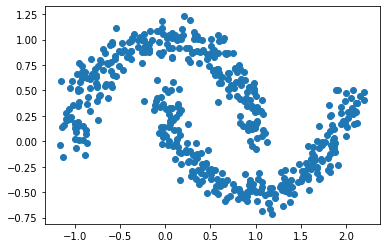

In [5]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

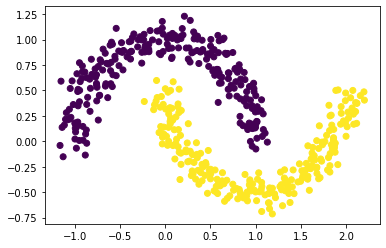

Wall time: 2.82 s


In [32]:
%%time
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

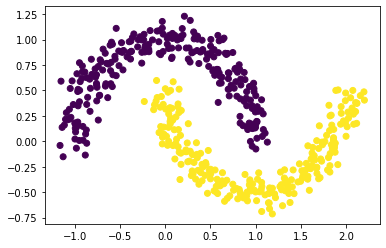

Wall time: 868 ms


In [33]:
%%time
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [39]:
from sklearn import datasets

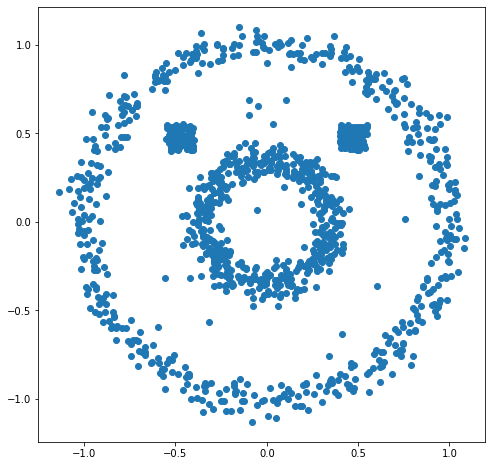

In [143]:
X, _ = datasets.make_circles(n_samples=(500, 500), noise=0.05, factor=0.35)
X1 = np.random.uniform(0.4, 0.55, [100, 2])
x2 = np.random.uniform(-0.55, -0.4, 100).reshape(-1, 1)
y2 = np.random.uniform(0.4, 0.55, 100).reshape(-1, 1)
X2 = np.hstack((x2, y2))
X3 = np.random.uniform(-1, 1, [40, 2])
X = np.concatenate((X, X1, X2, X3), axis=0)

fig = plt.subplots(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1])
plt.show()

Или хотя бы что-нибудь такое: 

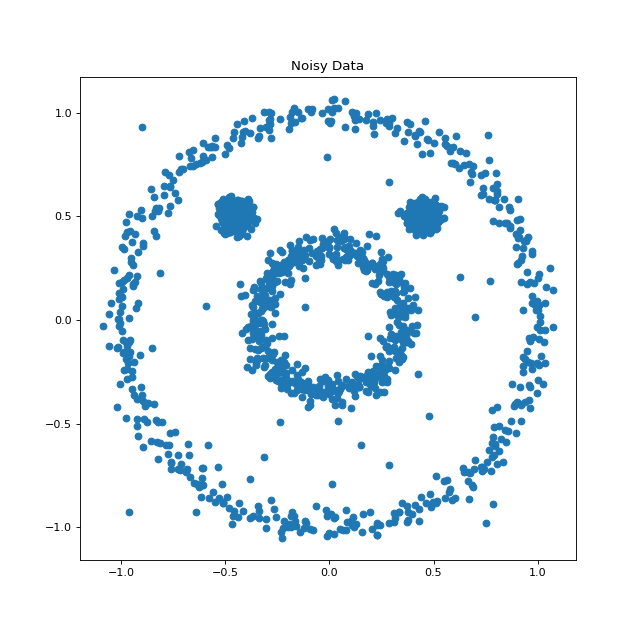

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [144]:
%%time
%%capture
clusters = DBSCAN(eps=0.143, min_samples=15).fit_predict(X)

Wall time: 22 ms


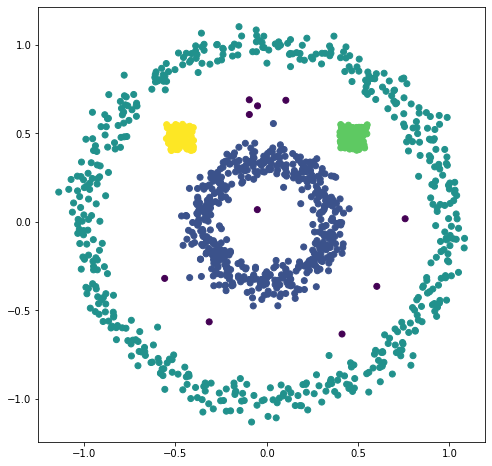

In [145]:
fig = plt.subplots(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

In [146]:
%%time
%%capture
clusters = dbscan(eps=0.143, min_samples=15).fit_predict(X)

Wall time: 34.9 s


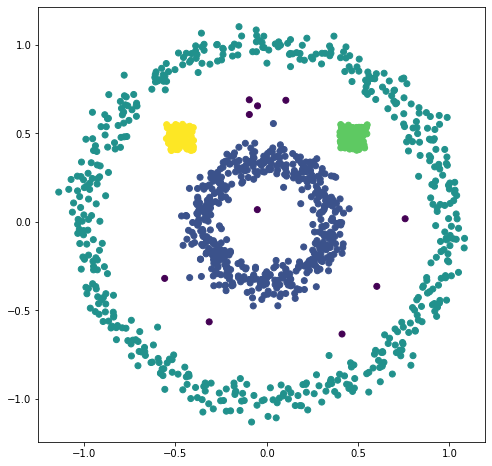

In [147]:
fig = plt.subplots(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()